<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Embedding-изображений">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Embedding изображений
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Обучение-модели">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Тестирование-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Тестирование модели
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Лабораторная работа № 1: Embedding изображений

**Задача:** проработать задачи с применением Embedding к изображениям:

1. Построить Embedding над изображениями (приложить к изображениям, чтобы каждой соответствовал вектор - применить в любом виде KNN для формирования датасета из векторов).
2. Подать на вход обученной на изображениях модели свои изображения.

**Источник данных:** [food-11 Image Classification Dataset](https://www.kaggle.com/datasets/imbikramsaha/food11?resource=download)

**Описание данных:** фотографии еды с 11ю категориями (мини-версия датасета food-101)

---

# Реализации

1. [Метрические алгоритмы](01_laboratory_work_1.ipynb)
2. Embedding над изображениями (текущий файл)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture no-display
!pip install kaggle mediapipe

Импорт необходимых библиотек:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List, Tuple, Dict
from tqdm.notebook import tqdm
import os
import glob
import random

import kaggle
import zipfile as zf
from zipfile import ZipFile

import mediapipe as mp

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from utils.plot_charts import plot_random_image, plot_image_predictions
from utils.useful_funcs import walk_through_dir

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Добавление папки с наборами данных:

In [3]:
if os.path.isdir('data') == False:
    os.mkdir('data')

Скачивание набора данных:

In [4]:
if os.path.isdir('data/food11') == False:
    os.chdir('data/')
    
    # remember to update .kaggle token file (C:/Users/<Username>/kaggle)
    !kaggle datasets download -d imbikramsaha/food11
    
    with zf.ZipFile('food11.zip', 'r') as file:
        file.extractall('.')
        
    os.remove('food11.zip')
    
    os.chdir('..')

Задание путей до тренировочного и тестового набора данных:

In [5]:
path_data = 'data/food11/'
path_train = path_data + 'train/'
path_test = path_data + 'test/'

Выведение на экран изображения и его параметров:

Путь к изображению: data\food11\train\french_fries\963995.jpg
Класс изображения: french_fries
Высота: 306 | Ширина: 512
Размерность изображения (306, 512, 3) -> [height, width, color_channels]


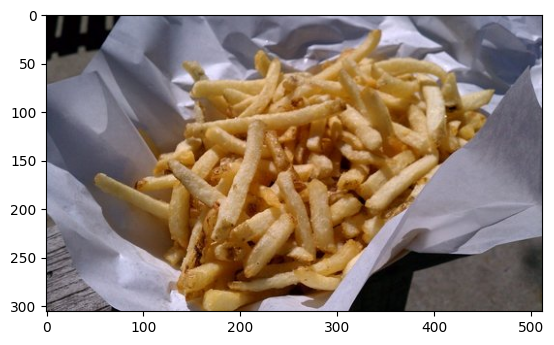

In [6]:
plot_random_image(path_train, depth='*/*')

In [7]:
walk_through_dir(path_data)

Путь: data/food11/ -> Каталогов: 2

	Каталог test -> Каталогов: 11
	├── Класс apple_pie -> Изображений: 100
	├── Класс cheesecake -> Изображений: 100
	├── Класс chicken_curry -> Изображений: 100
	├── Класс french_fries -> Изображений: 100
	├── Класс fried_rice -> Изображений: 100
	├── Класс hamburger -> Изображений: 100
	├── Класс hot_dog -> Изображений: 100
	├── Класс ice_cream -> Изображений: 100
	├── Класс omelette -> Изображений: 100
	├── Класс pizza -> Изображений: 100
	└── Класс sushi -> Изображений: 100

	Каталог train -> Каталогов: 11
	├── Класс apple_pie -> Изображений: 900
	├── Класс cheesecake -> Изображений: 900
	├── Класс chicken_curry -> Изображений: 900
	├── Класс french_fries -> Изображений: 900
	├── Класс fried_rice -> Изображений: 900
	├── Класс hamburger -> Изображений: 900
	├── Класс hot_dog -> Изображений: 900
	├── Класс ice_cream -> Изображений: 900
	├── Класс omelette -> Изображений: 900
	├── Класс pizza -> Изображений: 900
	└── Класс sushi -> Изображений: 900



<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Embedding изображений

**Embedding** - это векторное представление текста.

**Embedding изображений** - численное представление изображений.

*Source code: https://developers.google.com/mediapipe/solutions/vision/image_embedder/python*

---

Задание функции формирования эмбеддингов:

In [8]:
def create_embeddings(path: str) -> Tuple:
    with ImageEmbedder.create_from_options(options) as embedder:
        embeddings = []
        labels = []
        
        for subfolder in tqdm(os.listdir(path), 'Process'):
            subfolder_path = os.path.join(path, subfolder)
            
            for image in glob.glob(subfolder_path + '/*.jpg'):
                mp_image = mp.Image.create_from_file(image)
                embedded_image = embedder.embed(mp_image)

                embeddings.append(embedded_image.embeddings[0].embedding)
                labels.append(subfolder)
    
        return embeddings, labels

Задание функции обучения по параметру:

In [9]:
def train(model: KNeighborsClassifier,
          param: Dict[str, int], 
          X_train: List[int], 
          y_train: List[str]) -> Tuple[np.array, KNeighborsClassifier]:
    
    accuracy_param = []
    acc = 0
    best_model = None
    
    param_name = list(param.keys())[0]
    param_value = list(param.values())[0]
    
    for val in tqdm(param_value, 'Training process'):
        param = {param_name: val}
        
        model = KNeighborsClassifier(**param)
        model.fit(np.array(X_train), np.array(y_train))

        pred = model.predict(np.array(X_train))
        accuracy = accuracy_score(np.array(y_train), pred)
        
        if accuracy > acc:
            best_model = model
            acc = accuracy
        
        accuracy_param.append((accuracy, val))
        
        print(f'{param_name} = {val} | Accuracy: {acc:.03}')

    return np.array(accuracy_param), best_model

Задание функции получения предсказаний на одном изображении:

In [10]:
def train_single(model: KNeighborsClassifier, path: str) -> str:
    
    with ImageEmbedder.create_from_options(options) as embedder:
        mp_image = mp.Image.create_from_file(path)
        embedded_image = embedder.embed(mp_image).embeddings[0].embedding
        
        pred = model.predict(np.array(embedded_image).reshape(1, -1))
        return pred

---

### 3.1 Обучение модели

Задание переменных:

In [11]:
BaseOptions = mp.tasks.BaseOptions
ImageEmbedder = mp.tasks.vision.ImageEmbedder
ImageEmbedderOptions = mp.tasks.vision.ImageEmbedderOptions
VisionRunningMode = mp.tasks.vision.RunningMode

Задание пути до модели:

In [12]:
path_model = 'models/mobilenet_v3_small_075_224_embedder.tflite'

Настройка параметров:

In [13]:
options = ImageEmbedderOptions(
    base_options=BaseOptions(model_asset_path=path_model),
    quantize=True,
    running_mode=VisionRunningMode.IMAGE)

Формирование эмбеддингов изображений:

In [14]:
train_embeddings, train_labels = create_embeddings(path_train)

Process:   0%|          | 0/11 [00:00<?, ?it/s]

Выведение на экран экземпляра выборки:

In [15]:
print('Embedded image:', train_embeddings[0])
print('Label:', train_labels[0])

Embedded image: [212 213   2 ...  19 211 208]
Label: apple_pie


Обучение модели:

In [16]:
accuracy_param, model = train(
    KNeighborsClassifier(), 
    param={'n_neighbors': range(1, 21)},
    X_train=train_embeddings,
    y_train=train_labels
)

Training process:   0%|          | 0/20 [00:00<?, ?it/s]

n_neighbors = 1 | Accuracy: 1.0
n_neighbors = 2 | Accuracy: 1.0
n_neighbors = 3 | Accuracy: 1.0
n_neighbors = 4 | Accuracy: 1.0
n_neighbors = 5 | Accuracy: 1.0
n_neighbors = 6 | Accuracy: 1.0
n_neighbors = 7 | Accuracy: 1.0
n_neighbors = 8 | Accuracy: 1.0
n_neighbors = 9 | Accuracy: 1.0
n_neighbors = 10 | Accuracy: 1.0
n_neighbors = 11 | Accuracy: 1.0
n_neighbors = 12 | Accuracy: 1.0
n_neighbors = 13 | Accuracy: 1.0
n_neighbors = 14 | Accuracy: 1.0
n_neighbors = 15 | Accuracy: 1.0
n_neighbors = 16 | Accuracy: 1.0
n_neighbors = 17 | Accuracy: 1.0
n_neighbors = 18 | Accuracy: 1.0
n_neighbors = 19 | Accuracy: 1.0
n_neighbors = 20 | Accuracy: 1.0


>Количество соседей не влияет на качество модели.

---

### 3.2 Тестирование модели

Получение предсказаний произвольных изображений из тестовой выборки:

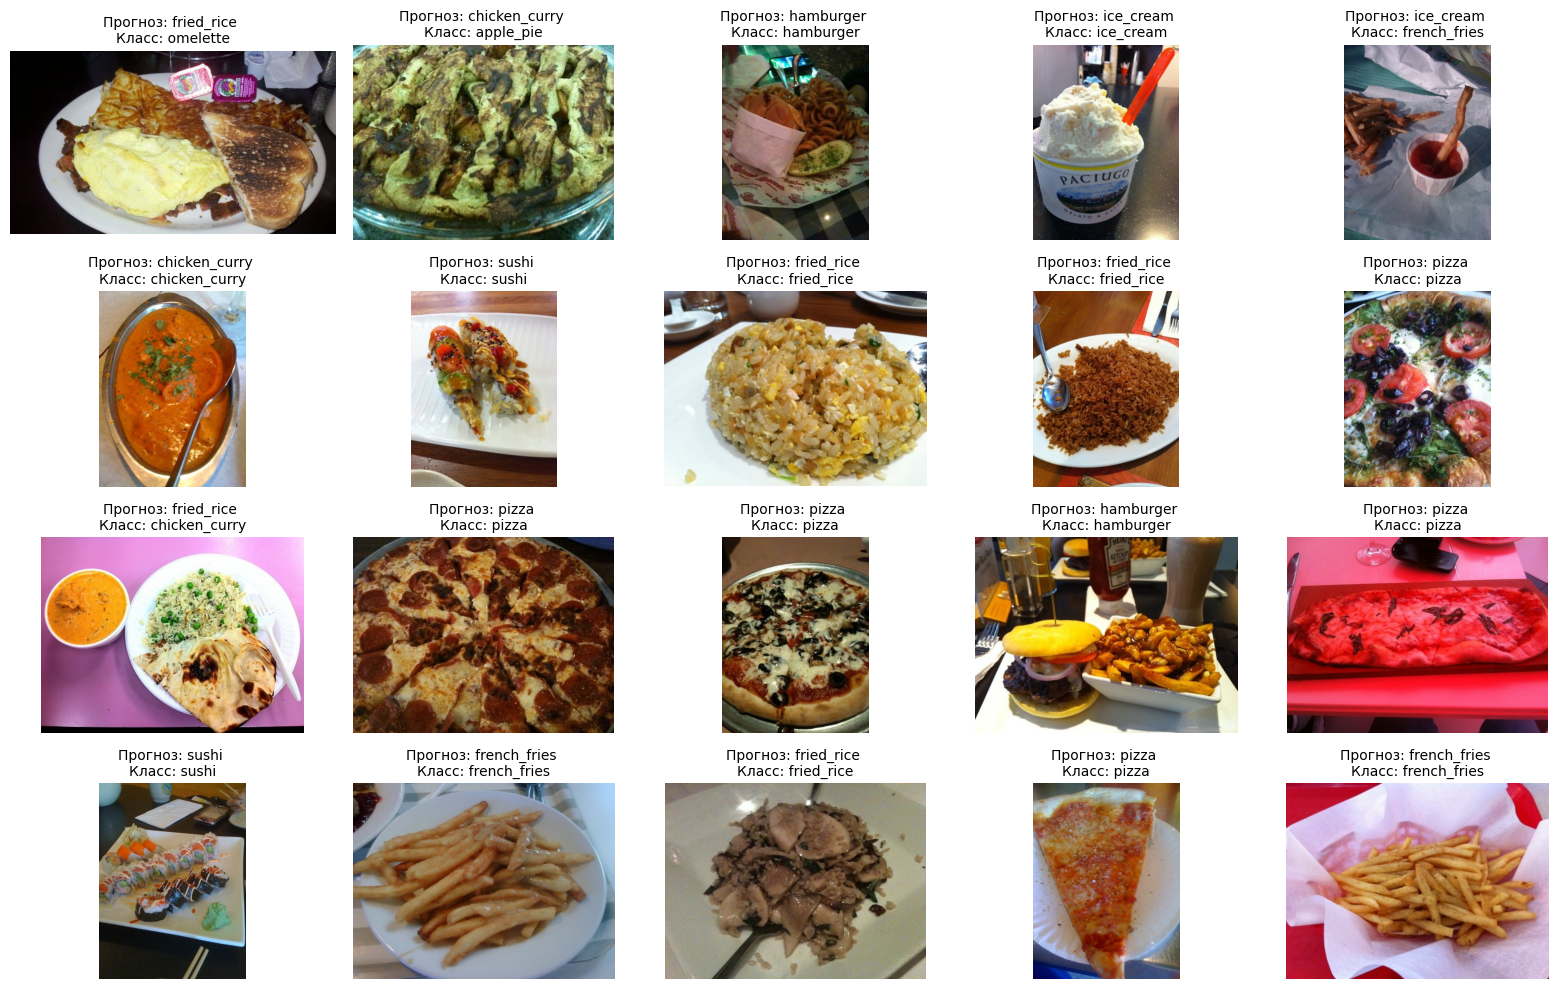

In [17]:
plot_image_predictions(model, train_single, path_test, 20)

>В основном модель даёт правильные ответы.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Изображения были приведены к численному представлению посредством метода эмбеддинга с демонстрацией предсказаний модели на тестовых изображениях. Однако в ходе тестирования было замечено, что предсказания модели не всегда правильно классифицирует изображения - необходимо произвести аугментации изображений и улучшить модель, чтобы добиться лучшего результата.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>